MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: July 3, 2021<br>
Last Modified: December 12, 2021<br>

**Label: Final Workflow, Script 8**<br>
Script Purpose:<br>
Script for analyzing uncertainty in results based on input data
<br><br>


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [2]:
#!apt update
#!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely==1.7.1 --no-binary shapely
!pip install rasterio==1.2.6 --no-binary rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 2s (962 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

from pathlib import Path
import pickle as pkl

from scipy import stats
import math

import geopandas as gpd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#import rasterio
import rasterio
from rasterio.plot import show

from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

Load models from saved pickle files

In [6]:
datafolder = Path(path) 

VERSION = 4

if(VERSION == 4):
  with open(datafolder/ "wellsp4_shared.pkl",'rb') as handle:
    datadict = pkl.load(handle)
elif (VERSION == 8):
  with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
else:
  with open(datafolder/ "wells_shared.pkl","rb") as handle:
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)

In [7]:
coords

,Latitude,Longitude
0,31.500146,-108.750621
1,31.510146,-108.750621
2,31.500146,-108.740621
3,31.500146,-108.760621
4,31.500148,-108.500614
...,...,...
2968,35.216759,-107.327307
2969,35.210060,-107.317307
2970,35.190060,-107.317307
2971,35.200060,-107.307307


In [8]:
# drop columns already determined to be colinear or are predicted variables
dropcols = ['AirTemperature','GeothermGrad_2class']
print(dropcols)
Xtr = X_train.drop(dropcols,axis=1)

# 4-class model 
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes
yc_full4  = fulldf.GeothermGrad_4class.cat.codes

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_full = le.transform(yc_full4)

# add coordinates back to fulldf
fulldf2 = pd.concat([coords,fulldf],axis=1)

['AirTemperature', 'GeothermGrad_2class']


In [9]:
# scale and transform data
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = list(Xtr.columns)
pl.fit(Xtr,yc_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr), columns=colnames)

load stderr raster fr Si_Geothermometry

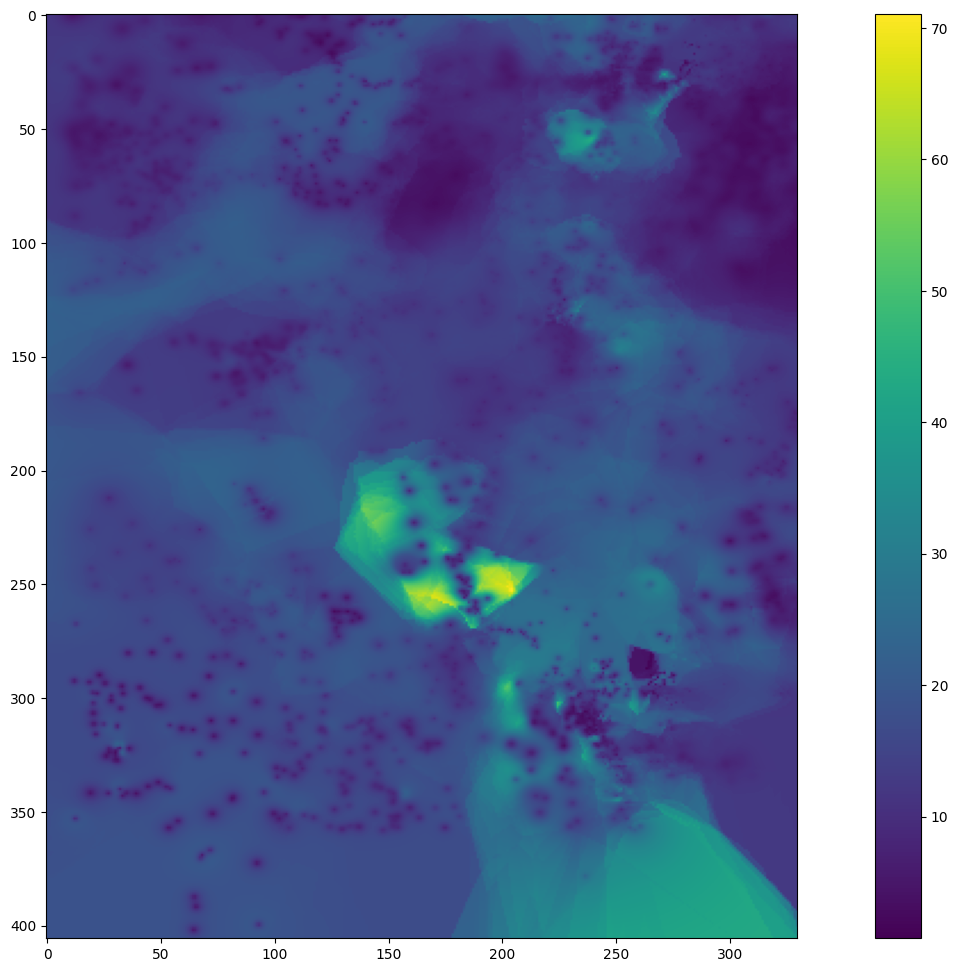

In [11]:
fn = r'Si_Geotherm_emp_bayes_kriging_stderr.tif'

stderr= rasterio.open(datafolder/fn)
array = stderr.read()

with mpl.style.context('default'):
  fig, ax = plt.subplots(1, figsize=(20, 12))
  plt.imshow(array[0],cmap='viridis')
  #plt.scatter(coords.Longitude, coords.Latitude, marker='o')
  plt.colorbar();

extract stderr values from raster at well locations

In [12]:
si_stderr = list();
for val in stderr.sample([(x,y) for x,y in zip(fulldf2.Longitude,fulldf2.Latitude)]):
  si_stderr.append(val[0])
fulldf2['SiGeothermometry_stderr'] = si_stderr

In [13]:
fulldf2[['Latitude','Longitude','SiGeothermometry','SiGeothermometry_stderr']].head()

,Latitude,Longitude,SiGeothermometry,SiGeothermometry_stderr
0,31.500146,-108.750621,61.101463,18.514156
1,31.510146,-108.750621,61.101814,18.515015
2,31.500146,-108.740621,61.101677,18.513935
3,31.500146,-108.760621,61.101292,18.514305
4,31.500148,-108.500614,59.408203,7.397952


test plotting stderr on well data

In [14]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    #ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    grayval = 255 #200
    ax.background_patch.set_facecolor((grayval/255, grayval/255, grayval/255))
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None',
                   #edgecolor='r', linewidth=2, alpha = 0.5)
                   edgecolor='k', linewidth=3, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    # plot lat/lon grid 
    ax.gridlines(crs = myprojection, draw_labels=True,
                 linewidth=0.5, color='k', alpha=0.25, linestyle='-')
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


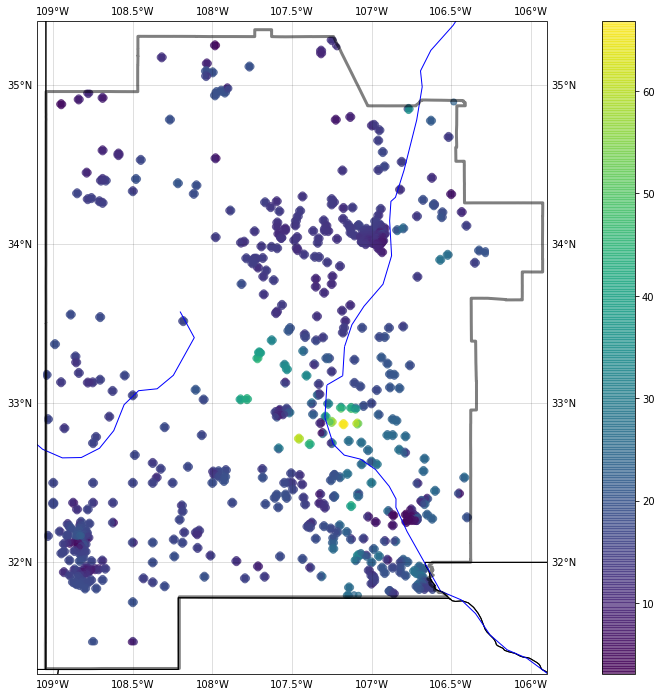

In [15]:
ax = createBasemap();
gdf = gpd.GeoDataFrame(datadict['coords'], crs = {'init': 'epsg:4326'})
gdf['SiGeothermometry_stderr'] = fulldf2.SiGeothermometry_stderr
pc = ax.scatter(gdf.Longitude,
                gdf.Latitude,
                cmap='viridis',
                c=gdf.SiGeothermometry_stderr,
                alpha=0.7,
                transform=myprojection);
plt.colorbar(pc);

Generate 100 New Data Sets

In [16]:
n_new = 100 # number of datasets
sigeos = np.empty(shape=(n_new,fulldf2.shape[0]))
for i in range(n_new):
  for j in range(fulldf2.shape[0]):
    sigeos[i][j] = np.random.normal(loc=0.0, scale=fulldf2.SiGeothermometry_stderr[j])+fulldf2.SiGeothermometry[j]

In [17]:
# replace first permutation with original data
sigeos[0] = fulldf2.SiGeothermometry.copy(deep=True).to_numpy()

# view results
sigeos

array([[ 61.1014633 ,  61.1018143 ,  61.1016769 , ...,  22.8893051 ,
         24.7361965 ,  25.0788937 ],
       [ 96.52052905,  73.97577079,  55.16510902, ...,  13.90721048,
         35.81043208,  35.09598331],
       [ 68.93660567,  40.36577578,  65.01918529, ...,  18.23598698,
         17.79458237,  27.87599611],
       ...,
       [ 59.69086337,  46.71037871,  65.14907688, ...,  42.9246759 ,
         21.40670032,  14.18390682],
       [ 54.26260912,  61.31192274,  77.24268122, ...,  18.02458074,
         18.61813144,  18.98983083],
       [ 69.94758171,  60.99287703, 111.231072  , ...,  16.00783883,
         28.49459154,  33.43813974]])

### Build XGBoost Models

Use tuned XGB model parameters from before

In [18]:
best_params = {}
if VERSION == 4:
  best_params = {'max_depth': 5,
                'min_child_weight': 3,
                'gamma': 0.1,
                'subsample': 0.6,
                'colsample_bytree': 0.5,
                'reg_lambda': 1.27,
                'scale_pos_weight': 0.0,
                'learning_rate':0.005,
                'n_estimators':1000}
elif VERSION == 8:
  best_params = {'max_depth': 4,
                'min_child_weight': 3,
                'gamma': 0.2,
                'subsample': 0.5,
                'colsample_bytree': 0.5,
                'reg_lambda': 1.27,
                'scale_pos_weight': 0.0,
                'learning_rate':0.005,
                'n_estimators':1750}
else:
  best_params = {'max_depth': 5,
                'min_child_weight': 7,
                'gamma': 0.1,
                'subsample': 0.5,
                'colsample_bytree': 0.6,
                'reg_lambda': 1.27,
                'scale_pos_weight': 0.0,
                'learning_rate':0.005,
                'n_estimators':1000}  

Load FDS and Prep the data

In [19]:
shapcolnames = ['DEM',
 'Gravity',
 'BasementDepth',
 'CrustalThickness',
 'StrainRate',
 'QFaults',
 'StateFaults',
 'Drainage',
 'VolcanicDikes',
 'SiGeothermometry',
 'Lithium',
 'Boron',
 'HeatFlow',
 'Earthquakes',
 'Vents',
 'Springs']

# load Full Data Set for map prediction
with open(datafolder/ "full_shared.pkl","rb") as handle:
  datadict = pkl.load(handle)
    
# unpack data
FDSdf     = datadict['data']
FDScoords = datadict['coords']
#pfa_result = FULLdf['GeothermGrad_4class']

# scale data
FDSdf = FDSdf[Xtrsc.columns]
FDSdfsc = pd.DataFrame(pl.transform(FDSdf), columns=Xtrsc.columns)

# down-select to only include key features from shapley analysis
FDSdf = FDSdf[shapcolnames]
FDSdfsc = FDSdfsc[shapcolnames]

Create structure to hold model results

In [20]:
# structure to hold model results
nc = 4 # number of classes
ns = FDSdfsc.shape[0]
model_results = np.empty(shape=(n_new,ns,nc))

Run XBG classifier repeatedly to build different models

In [21]:
ytrain = pd.Series(yenc_full,name='GeothermGrad')

for i in range(n_new):
  print('Predicting on dataset ',i+1)

  #######################
  # change out the data
  #######################
  fulldf2['SiGeothermometry'] = sigeos[i]

  # scale and transform data
  xtrain = pd.DataFrame(pl.transform(fulldf2[Xtrsc.columns]), columns=Xtrsc.columns)

  # restrict to Shapley-determined important features
  xtrain = xtrain[shapcolnames]

  # build XGBoost model
  xgb_model = XGBClassifier(learning_rate=best_params['learning_rate'],
                            n_estimators=best_params['n_estimators'],
                            max_depth=best_params['max_depth'], 
                            min_child_weight=best_params['min_child_weight'],
                            gamma=best_params['gamma'], 
                            subsample=best_params['subsample'], 
                            colsample_bytree=best_params['colsample_bytree'],
                            reg_lambda=best_params['reg_lambda'],
                            scale_pos_weight=best_params['scale_pos_weight'],
                            objective='multi:softprob',
                            n_jobs=-1,
                            seed=seed)
  # fit model
  xg_model = xgb_model.fit(xtrain,ytrain,verbose=1)

  # predict on FDS and save results
  model_results[i] = xg_model.predict_proba(FDSdfsc)

Predicting on dataset  1
Predicting on dataset  2
Predicting on dataset  3
Predicting on dataset  4
Predicting on dataset  5
Predicting on dataset  6
Predicting on dataset  7
Predicting on dataset  8
Predicting on dataset  9
Predicting on dataset  10
Predicting on dataset  11
Predicting on dataset  12
Predicting on dataset  13
Predicting on dataset  14
Predicting on dataset  15
Predicting on dataset  16
Predicting on dataset  17
Predicting on dataset  18
Predicting on dataset  19
Predicting on dataset  20
Predicting on dataset  21
Predicting on dataset  22
Predicting on dataset  23
Predicting on dataset  24
Predicting on dataset  25
Predicting on dataset  26
Predicting on dataset  27
Predicting on dataset  28
Predicting on dataset  29
Predicting on dataset  30
Predicting on dataset  31
Predicting on dataset  32
Predicting on dataset  33
Predicting on dataset  34
Predicting on dataset  35
Predicting on dataset  36
Predicting on dataset  37
Predicting on dataset  38
Predicting on dataset

In [22]:
model_results

array([[[0.00985066, 0.02335748, 0.87270612, 0.09408575],
        [0.00986623, 0.02351847, 0.87171251, 0.09490281],
        [0.01030208, 0.03424448, 0.86690521, 0.08854824],
        ...,
        [0.79663092, 0.10668284, 0.03621619, 0.06047008],
        [0.67829424, 0.19976856, 0.0536891 , 0.0682481 ],
        [0.34111983, 0.46622658, 0.0878505 , 0.10480313]],

       [[0.01046219, 0.0250793 , 0.87903827, 0.08542018],
        [0.01036652, 0.02496811, 0.87775177, 0.08691355],
        [0.01066249, 0.04151982, 0.86520755, 0.08261006],
        ...,
        [0.7491163 , 0.12684944, 0.04792129, 0.07611298],
        [0.60065228, 0.23066123, 0.06614179, 0.1025447 ],
        [0.27959689, 0.47874543, 0.09696322, 0.14469443]],

       [[0.01074146, 0.02590678, 0.87084377, 0.09250804],
        [0.01068854, 0.02553829, 0.87030137, 0.09347181],
        [0.01091783, 0.04178198, 0.85788894, 0.08941119],
        ...,
        [0.73831207, 0.13515888, 0.05015499, 0.07637402],
        [0.60845792, 0.224480

generate mean model and model entropy

In [23]:
# Distribution summation
sum_models = np.sum(model_results,axis=0)

# Calculate entropy from distsum
ent_models = stats.entropy(sum_models,base=nc,axis=-1)

In [25]:
np.argmax(sum_models,axis=1)

array([2, 2, 2, ..., 0, 0, 1])

plot results

In [ ]:
# SHORTCUT TO LOAD RESULTS

with open(datafolder / 'measure_uncertainty_sigeo.pkl',"rb") as handle:
  prevrun = pkl.load(handle)
fulldf2 = prevrun['fullds']
yenv_full = prevrun['fullds_yenc']
model_results = prevrun['models']
sigeos = prevrun['sigeo_values']
nc = 4
sum_models = np.sum(model_results,axis=0)
ent_models = stats.entropy(sum_models,base=nc,axis=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


<Figure size 2000x1200 with 0 Axes>

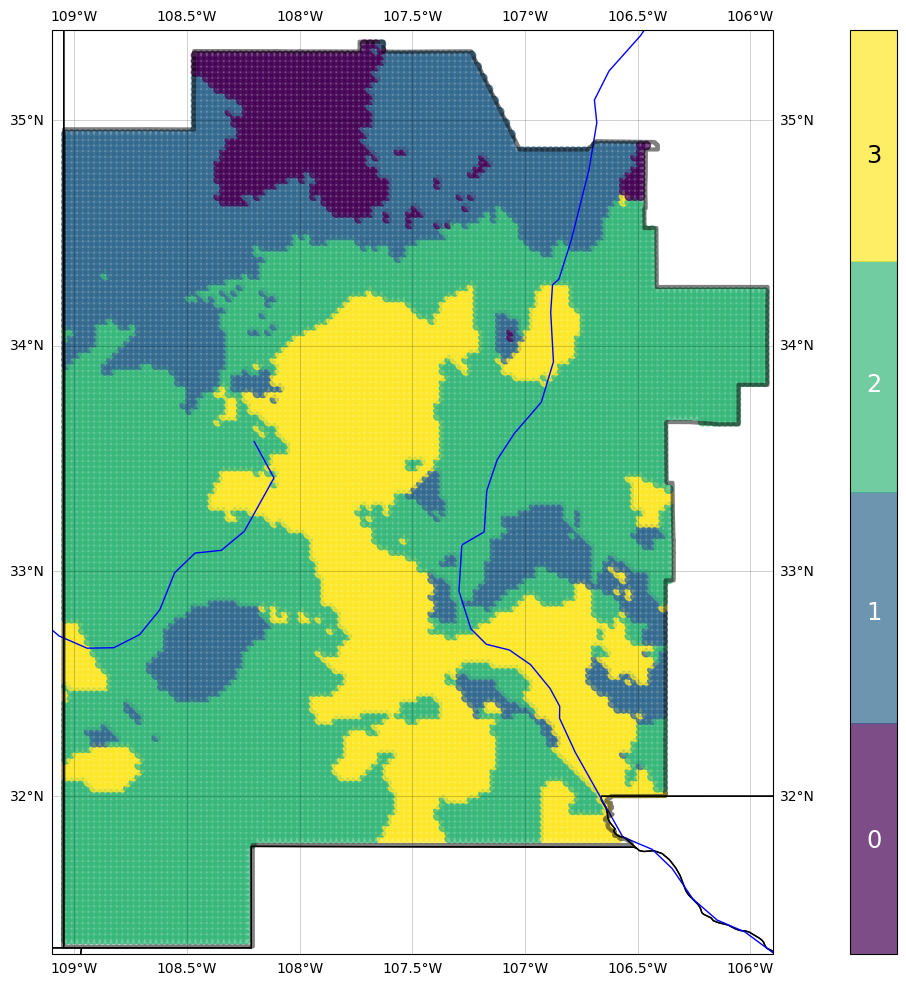

In [27]:
# Ensemble Model Plot

with mpl.style.context('default'):
  plt.figure(figsize=(20,12))
  ax = createBasemap();
  colmap=plt.cm.get_cmap('viridis', 4)
  
  cbar = plt.colorbar(pc)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
      
  pc = ax.scatter(FDScoords.Longitude,
                  FDScoords.Latitude,
                  cmap=colmap,
                  c=np.argmax(sum_models,axis=1),
                  alpha=.7,
                  transform=myprojection);

plt.savefig(datafolder / 'Fig-DistributionSummation-FeatureUncertainty.png', bbox_inches='tight')

In [28]:
sigt_points = pd.read_csv(str(datafolder / 'combined_data_Si_Geothermometry.csv'))

FDS_si_stderr = list();
for val in stderr.sample([(x,y) for x,y in zip(FDScoords.Longitude,FDScoords.Latitude)]):
  FDS_si_stderr.append(val[0])
FDSdf['SiGeothermometry_stderr'] = FDS_si_stderr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


<Figure size 432x288 with 0 Axes>

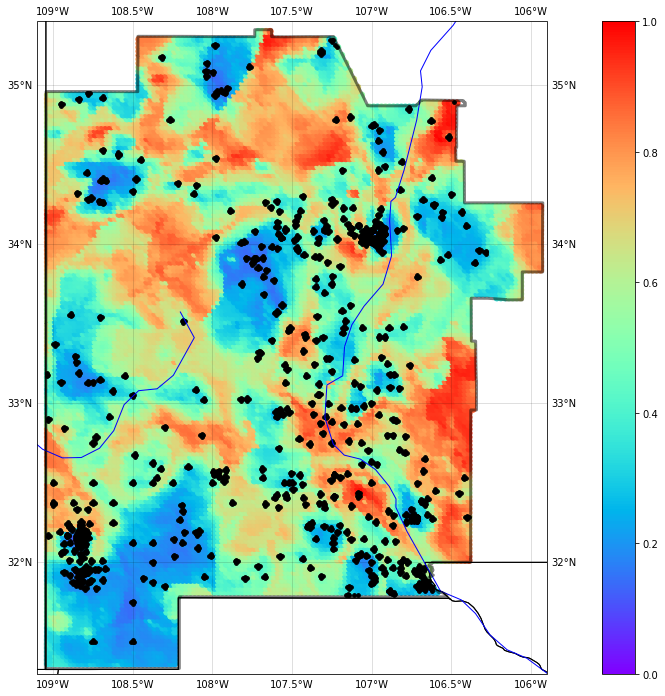

In [29]:
# Entropy Plot

plt.figure()
ax = createBasemap();
pc = ax.scatter(FDScoords.Longitude,
                FDScoords.Latitude,
                cmap='rainbow',
                c=ent_models,
                alpha=1.,
                vmin=0.0,
                vmax=1.0,
                transform=myprojection);

plt.colorbar(pc);
plt.savefig(datafolder/'Fig-Entropy_FeatureUncertainty_nopts.png', bbox_inches='tight')

# add points
gdf = gpd.GeoDataFrame(coords, crs = {'init': 'epsg:4326'})
ax.scatter(gdf.Longitude,
            gdf.Latitude,
            c='black',
            marker='o',
            s=14,
            alpha=1.0,
            transform=myprojection);  
plt.savefig(datafolder/'Fig-Entropy_FeatureUncertainty_withpts.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


<Figure size 1440x864 with 0 Axes>

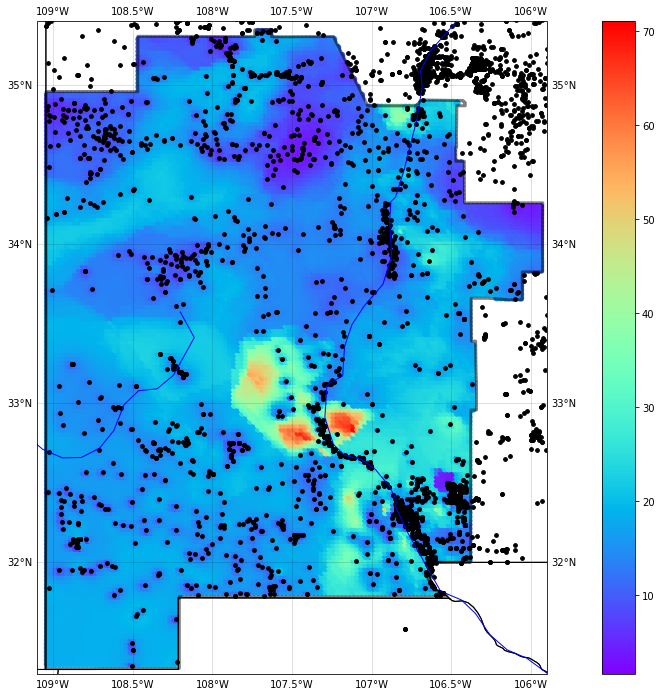

In [30]:
# Si Geothermometer Temperature stderr

plt.figure(figsize=(20,12))
ax = createBasemap();
pc = ax.scatter(FDScoords.Longitude,
                FDScoords.Latitude,
                cmap='rainbow',
                c=FDSdf.SiGeothermometry_stderr,
                alpha=1.,
                transform=myprojection);
plt.colorbar(pc);
plt.savefig(datafolder/'Fig-SiGT_stderr_nopts.png', bbox_inches='tight')

# add points
ax.scatter(sigt_points.Longitude,
            sigt_points.Latitude,
            marker='o',s=14,
            c='black',transform=myprojection)
plt.savefig(datafolder/'Fig-SiGT_stderr_withpts.png', bbox_inches='tight')

create regular grid

In [32]:
from scipy.interpolate import griddata
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
numx = int(((xmax-xmin)/.025) +1)
numy = int(((ymax-ymin)/.025) +1)
xi = np.linspace(xmin,xmax,numx)
yi = np.linspace(ymin,ymax,numy)
grid_x, grid_y = np.meshgrid(xi,yi)
zi = griddata((FDScoords.Longitude,FDScoords.Latitude),np.argmax(sum_models,axis=1), (xi[None,:], yi[:,None]),method='nearest')
ai = griddata((FDScoords.Longitude,FDScoords.Latitude),1-ent_models, (xi[None,:], yi[:,None]),method='nearest')

In [33]:
# create base image for map
expl_area = datafolder / 'Exploration_area.shp'
expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

gdf = gpd.GeoDataFrame({"Longitude":grid_x.reshape(-1,1).squeeze(), 
                        "Latitude":grid_y.reshape(-1,1).squeeze(), 
                        "GeothermalClass":zi.reshape(-1,1).squeeze(), 
                        "Unentropy":ai.reshape(-1,1).squeeze()},
                        crs = {'init': 'epsg:4326'})
gdf['geometry']=gpd.points_from_xy(gdf.Longitude,gdf.Latitude)
for p in expl_area_feat.geometries():
  break;
  
gdf=gpd.clip(gdf,p)

Build color transparency

In [34]:
norm = mpl.colors.Normalize(vmin=0.0, vmax=3.0)
cmap = mpl.cm.get_cmap('viridis',4)

#colors = [cmap(norm(c), alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]
colors = [cmap(c, alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]

Create masked combo plot

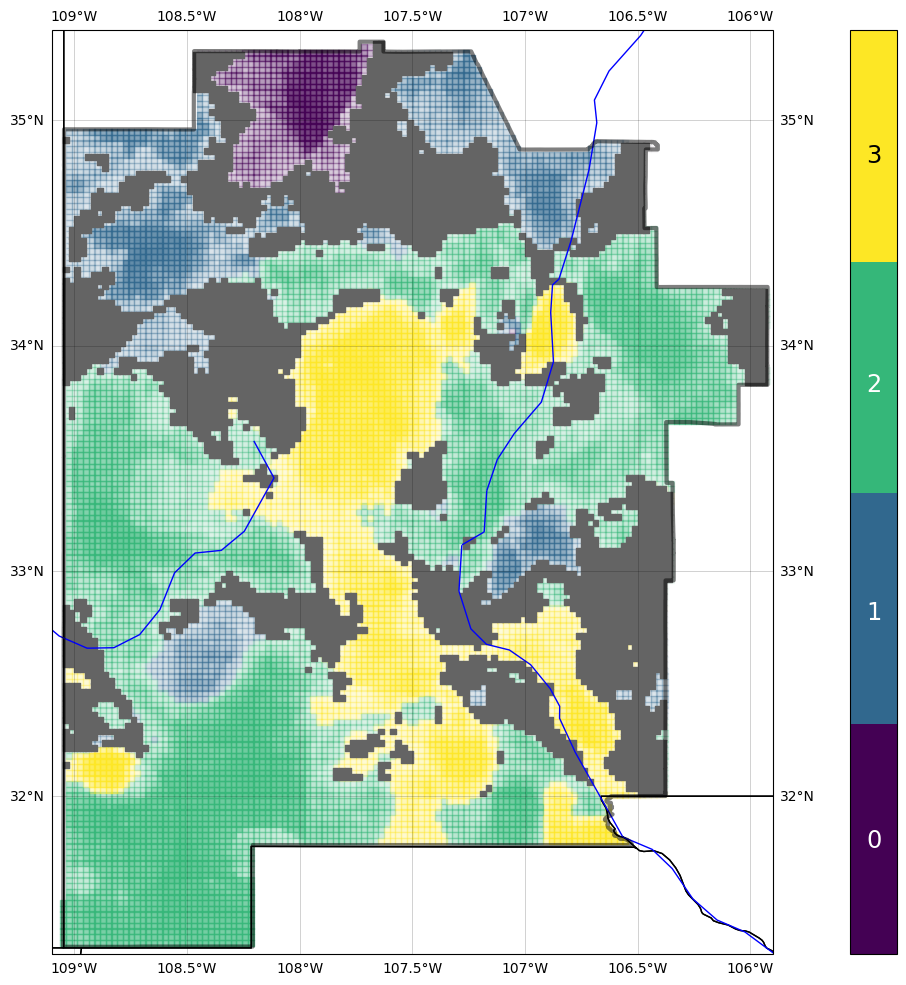

In [35]:
mask = True

with mpl.style.context('default'):
  plt.figure(figsize=(20,12))
  ax = plt.axes(projection=myprojection)
      
  ax.add_feature(cartopy.feature.STATES)
  rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
  ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
  ax.add_feature(expl_area_feat, facecolor='None', edgecolor='k', linewidth=3, alpha = 0.5)
  ax.set_extent(extent,crs=myprojection)
  
  # plot lat/lon grid 
  gl = ax.gridlines(crs = myprojection, draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.25, linestyle='-')
  
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  cmap = cmap,
                  alpha=1,
                  c=gdf.GeothermalClass,
                  s=0,
                  transform=myprojection)
  cbar = plt.colorbar(pc)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
      
  # plot actual symbols with transparency
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  c=colors,
                  marker='s',
                  s=18,
                  transform=myprojection)

  if mask == True:
   
    rgba_colors = np.zeros((len(ent_models),4))
    rgba_colors[:,0] = [0 if x<0.7 else 100/256 for x in ent_models]
    rgba_colors[:,1] = [0 if x<0.7 else 100/256 for x in ent_models]
    rgba_colors[:,2] = [0 if x<0.7 else 100/256 for x in ent_models]
    rgba_colors[:, 3] = [0 if x<0.7 else 1 for x in ent_models]
    pc = ax.scatter(FDScoords.Longitude,
                    FDScoords.Latitude,
                    marker='s',
                    s = 18,
                    color=rgba_colors,
                    transform=myprojection);

plt.savefig(datafolder / 'Fig-Masked_FeatureUncertainty.png', bbox_inches='tight')

Save results

In [41]:
# save out for use in other scripts
shared = {
          'coords':FDScoords,
          "full_dataset":fulldf2,
          "fullds_yenc":yenc_full,
          'sigeo_values':sigeos,
          'FULL_pp':model_results,
          'sum_FULL_pp':sum_models
         }
with open(datafolder / "measure_uncertainty_sigeo.pkl","wb") as handle:
    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)